# Case Ifood
*Desenvolvido por Mário de Deus*

# Installs

In [6]:
#No Google Colab será necessário executar as instalações abaixo a cada nova sessão.
#No Jupyter Notebook, Jupyter Lab ou VSCode (localhost) basta instalar uma única vez.
!pip install numba==0.60.0
!pip install pycaret==3.3.2
!pip install shap==0.47.1

  Using cached pycaret-3.0.4-py3-none-any.whl.metadata (17 kB)
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
  Using cached pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached scikit_learn-1.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached pyod-2.0.4.tar.gz (169 kB)
  Preparing metadata (setup.py) ... done
  Using cached category_encoders-2.8.1-py3-none-any.whl.metadata (7.9 kB)
  Using cached deprecation-2.1.0-py2.py3-none-any.whl.metadata (4.6 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached scikit_plot-0.3.7-py3-none-any.whl.metadata (7.1 kB)
  Using cached kaleido-0.2.1-py2.py3-none-manylinux1_x86_64.whl.metadata (15 kB)
  Using cached schemdraw-0.15-py3-none-any.whl.metadata (2.2 kB)
  Using cached plotly_resampler-0.10.0-py3-none-any.whl.metadata (13 kB

# Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from pycaret.classification import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_colwidth', 1000)

import warnings
warnings.filterwarnings('ignore')

# Descrição / Objetivo do problema

* O objetivo

O objetivo da equipe é construir um modelo preditivo que produzirá o maior lucro para a próxima campanha de marketing direto, programada para o próximo mês. A nova campanha, sexta, visa a venda de um novo gadget para clientes cadastrados no Banco de Dados da empresa. Para construir o modelo, foi realizada uma campanha piloto envolvendo 2.240 clientes. Os clientes foram selecionados aleatoriamente e contatados por telefone para a aquisição do gadget. Durante os meses seguintes, os clientes que compraram a oferta foram devidamente etiquetados. O custo total da campanha da amostra foi de 6,720MU e a receita gerada pelos clientes que aceitaram a oferta foi de 3,674MU. Globalmente, a campanha teve um lucro de -3,046MU. A taxa de sucesso da campanha foi de 15%. O objetivo da equipe é desenvolver um modelo que preveja o comportamento do cliente e aplicá-lo ao restante da base de clientes. Felizmente, o modelo permitirá que a empresa escolha a dedo os clientes com maior probabilidade de comprar a oferta, deixando de fora os não respondentes, tornando a próxima campanha altamente lucrativa. Além disso, além de maximizar o lucro da campanha, o CMO está interessado em estudar as características dos clientes que desejam comprar o gadget.
Os dados
O conjunto de dados contém características sociodemográficas e firográficas de cerca de 2.240 clientes contatados. Além disso, contém um sinalizador para aqueles clientes que responderam à campanha, comprando o produto.


# Data Loading

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [35]:
#Google COlab
# df = pd.read_csv('/content/drive/MyDrive/Front End e Mobile Development/2024/20240318 - Aula06/data.csv',encoding='utf-8')

#Jupyter
df = pd.read_csv('data.csv',encoding='utf-8')

df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


# Data Cleaning

Drop da feature ID por ser um identificador

In [36]:
df.drop('ID',axis = 1, inplace = True, errors = 'ignore')
df.shape

(2240, 28)

## Features com valores unicos
Verificando a existência de features com valores únicos (devem ser dropadas por não contribuirem para a explicar a variação da feature target)

In [37]:
df.nunique().sort_values()

,0
Z_Revenue,1
Z_CostContact,1
Response,2
AcceptedCmp3,2
AcceptedCmp4,2
AcceptedCmp5,2
AcceptedCmp2,2
AcceptedCmp1,2
Complain,2
Teenhome,3


In [38]:
df.drop(['Z_CostContact','Z_Revenue'],axis=1,inplace = True, errors = 'ignore')

## NaN analysis

In [39]:
df.isna().sum()

,0
Year_Birth,0
Education,0
Marital_Status,0
Income,24
Kidhome,0
Teenhome,0
Dt_Customer,0
Recency,0
MntWines,0
MntFruits,0


Somente a feature Income possui valores nulos.
Analisando as linhas com valores nulos em relação aos valores da feature target

In [40]:
#Distribuição da feature Response entre as amostras com Income = NaN
df[df.Income.isna()].Response.value_counts()

,count
Response,
0,23
1,1


In [41]:
# Proporção de 0 e 1 da feature Response no df completo
df.Response.value_counts(normalize = True)

,proportion
Response,
0,0.850893
1,0.149107


In [42]:
print('% amostras com NaN: ',np.round((df.Income.isna().sum()/len(df))*100,2))
print('% amostras com NaN e Response = 1: ',
      np.round((( len(df[(df.Income.isna()) & (df.Response == 1)]) / len(df))*100),2))

% amostras com NaN:  1.07
% amostras com NaN e Response = 1:  0.04


Dado que as 24 linhas com valores Nan representam 1% do dataset total, e que entre as 24 linhas com Income == Nan somente uma apresentou Response == 1 (0.04%), as 24 linhas serão dropadas

In [43]:
print('Shape antes do dropna: ',df.shape[0])
df.dropna(axis=0,inplace = True)
print('Shape após o dropna: ',df.shape[0])

Shape antes do dropna:  2240
Shape após o dropna:  2216


## Ajuste do dtypes

In [44]:
df = df.convert_dtypes()
df.Dt_Customer = pd.to_datetime(df.Dt_Customer)
df.Response = df.Response.astype('bool')
df.dtypes

,0
Year_Birth,Int64
Education,string[python]
Marital_Status,string[python]
Income,Int64
Kidhome,Int64
Teenhome,Int64
Dt_Customer,datetime64[ns]
Recency,Int64
MntWines,Int64
MntFruits,Int64


# Feature Engineering

## Idade dos clientes

In [45]:
from datetime import datetime
ano_atual = datetime.now().year
df['Age'] = ano_atual - df.Year_Birth
df.drop('Year_Birth',axis = 1, errors = 'ignore', inplace = True)
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age
0,Graduation,Single,58138,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,True,68
1,Graduation,Single,46344,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,False,71
2,Graduation,Together,71613,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,False,60
3,Graduation,Together,26646,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,False,41
4,PhD,Married,58293,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,False,44


## Tempo como cliente

In [69]:
dt = datetime.now().date()
df['Time_Customer'] = dt - pd.to_datetime(df['Dt_Customer']).dt.date
df['Time_Customer'] = df['Time_Customer'] / 365.25
def timedelta_to_fractional_days(timedelta):
    days = timedelta.days
    seconds = timedelta.seconds
    fractional_day = seconds / (24 * 60 * 60)
    return days + fractional_day

df['Time_Customer'] = df['Time_Customer'].apply(timedelta_to_fractional_days)

print(df[['Dt_Customer', 'Time_Customer']].head())
df.drop('Dt_Customer',axis = 1, inplace = True)

  Dt_Customer  Time_Customer
0  2012-09-04      12.605058
1  2014-03-08      11.099236
2  2013-08-21      11.644074
3  2014-02-10      11.170428
4  2014-01-19      11.230660


### Removendo valores incoerentes com a variável Marital_Status

In [70]:
index_to_drop = df[(df['Marital_Status'] =='YOLO') | (df['Marital_Status'] =='Absurd') | (df['Marital_Status'] =='absurd') | (df['Marital_Status'] == 'Alone')].index
df.drop(index_to_drop,inplace = True)
df = df.reset_index(drop = True)
df.Marital_Status.value_counts()
print(df.shape)

(2209, 26)


In [71]:
df.rename(columns={'Response':'z_Response'},inplace = True)
cols = df.columns.sort_values()
df = df[cols]
df.rename(columns={'z_Response':'Response'},inplace = True)

df.columns

Index(['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5', 'Age', 'Complain', 'Education', 'Income', 'Kidhome',
       'Marital_Status', 'MntFishProducts', 'MntFruits', 'MntGoldProds',
       'MntMeatProducts', 'MntSweetProducts', 'MntWines',
       'NumCatalogPurchases', 'NumDealsPurchases', 'NumStorePurchases',
       'NumWebPurchases', 'NumWebVisitsMonth', 'Recency', 'Teenhome',
       'Time_Customer', 'Response'],
      dtype='object')

# Preparação do dataset para Modelagem


## Train Test Validation Split

In [72]:
# sample 5% of data to be used as unseen data
df_train_test = df.sample(frac=0.95, random_state=123)
df_valid = df.drop(df_train_test.index)
df_train_test.reset_index(inplace=True, drop=True)
df_valid.reset_index(inplace=True, drop=True)
# print the revised shape
print('Data for Modeling: ' + str(df_train_test.shape))
print('Unseen Data For Predictions: ' + str(df_valid.shape))

Data for Modeling: (2099, 26)
Unseen Data For Predictions: (110, 26)


# Auto ML - PYCARET

**Para o problema de negócio em questão, a métrica Precision é a mais relevante.**

In [73]:
df_train_test.dtypes

,0
AcceptedCmp1,Int64
AcceptedCmp2,Int64
AcceptedCmp3,Int64
AcceptedCmp4,Int64
AcceptedCmp5,Int64
Age,Int64
Complain,Int64
Education,string[python]
Income,Int64
Kidhome,Int64


## Setup

In [74]:
s = setup(data = df_train_test,
          target = 'Response',
          fix_imbalance = True,
          remove_outliers = True,
          categorical_features = ['Education', 'Marital_Status'],
          session_id = 123)

,Description,Value
0,Session id,123
1,Target,Response
2,Target type,Binary
3,Original data shape,"(2099, 26)"
4,Transformed data shape,"(3072, 34)"
5,Transformed train set shape,"(2442, 34)"
6,Transformed test set shape,"(630, 34)"
7,Numeric features,23
8,Categorical features,2
9,Preprocess,True


In [75]:
# check available models
#has to be called necessary only after having defined a setup.
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsClassifier,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDClassifier,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessClassifier,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron.MLPClassifier,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


## Comparativo entre Modelos

In [78]:
best_model = compare_models(sort = 'auc')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8121,0.9005,0.8099,0.4380,0.5669,0.4613,0.4976,0.2540
lda,Linear Discriminant Analysis,0.8128,0.9004,0.8099,0.4389,0.5677,0.4624,0.4985,0.2790
gbc,Gradient Boosting Classifier,0.8741,0.8916,0.4478,0.6165,0.5155,0.4455,0.4548,1.7650
lightgbm,Light Gradient Boosting Machine,0.8727,0.8863,0.3802,0.6329,0.4700,0.4034,0.4229,2.0540
xgboost,Extreme Gradient Boosting,0.8836,0.8862,0.4933,0.6590,0.5573,0.4925,0.5032,0.5790
rf,Random Forest Classifier,0.8836,0.8785,0.3802,0.7094,0.4914,0.4333,0.4618,0.8420
ada,Ada Boost Classifier,0.8632,0.8658,0.5524,0.5535,0.5485,0.4685,0.4711,0.5470
et,Extra Trees Classifier,0.8870,0.8537,0.3798,0.7532,0.5003,0.4448,0.4803,0.6120
qda,Quadratic Discriminant Analysis,0.7614,0.8294,0.6613,0.4047,0.4855,0.3657,0.3822,0.2580
lr,Logistic Regression,0.7488,0.8133,0.7415,0.3448,0.4700,0.3333,0.3760,1.4020


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [79]:
print(best_model)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, positive=False, random_state=123, solver='auto',
                tol=0.0001)


## Análise do Modelo

In [80]:
#evaluate model
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

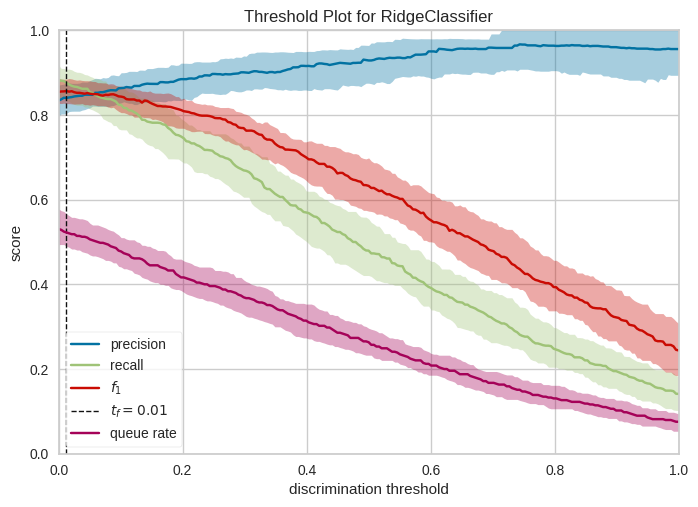

In [81]:
#plot model - treshold
plot_model(best_model, plot = 'threshold')

In [82]:
#plot model - auc
# plot_model(best_model, plot = 'auc')

TypeError: AUC plot not available for estimators with no predict_proba attribute.

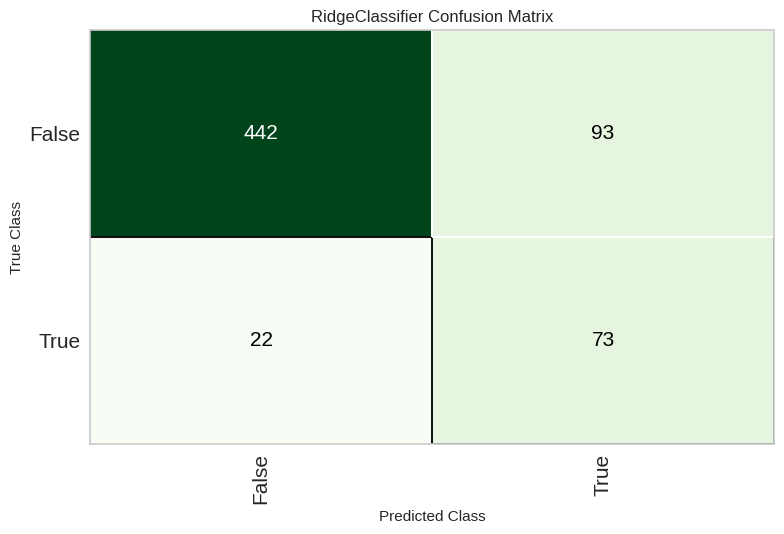

In [83]:
#plot model - confusion matrix
plot_model(best_model, plot = 'confusion_matrix')

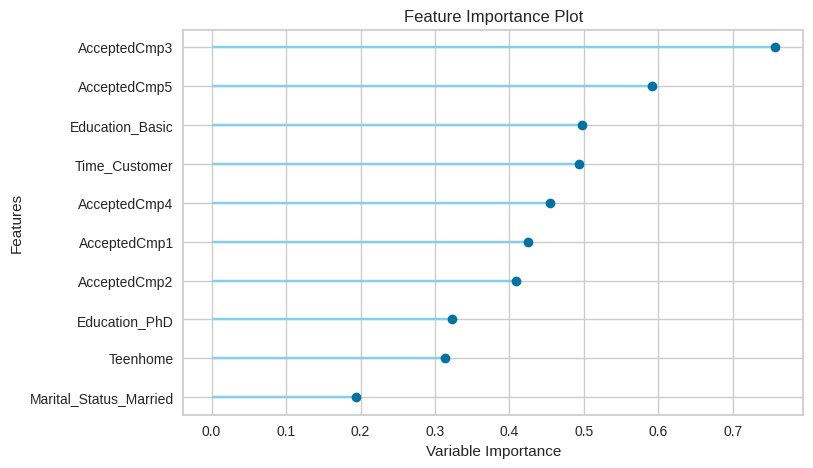

In [84]:
#plot model - feature
plot_model(best_model, plot = 'feature')

In [85]:
#predict model - raw score
predict_model(best_model, raw_score= True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.8175,0.7973,0.7684,0.4398,0.5594,0.4548,0.4830


,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Age,Complain,Education,Income,Kidhome,...,NumCatalogPurchases,NumDealsPurchases,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Teenhome,Time_Customer,Response,prediction_label
1869,0,0,0,0,0,66,0,PhD,67786,0,...,6,1,6,3,1,0,0,11.348392,True,1
1782,0,0,0,0,0,61,0,PhD,31686,1,...,0,2,3,1,6,31,1,10.855567,False,0
1944,0,0,0,0,0,75,0,PhD,59292,0,...,5,2,8,3,3,71,1,11.832986,False,0
1670,0,0,1,0,0,55,0,PhD,38097,1,...,2,4,2,3,7,70,1,12.492812,True,1
1219,0,0,0,0,0,49,0,Master,49681,0,...,1,6,7,7,7,66,2,11.438739,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0,0,0,0,0,50,0,Graduation,37085,1,...,0,4,3,3,8,65,1,10.798079,False,0
1923,1,0,0,0,0,60,0,Graduation,81168,0,...,4,1,7,6,3,84,0,10.934965,False,0
1523,0,0,0,0,0,47,0,2n Cycle,52195,2,...,0,1,2,1,8,2,1,10.921285,False,0
641,0,0,0,0,0,56,0,Graduation,4428,0,...,0,0,0,25,1,0,1,11.520868,False,0


* Outros tipos de plot:
https://pycaret.readthedocs.io/en/latest/api/classification.html#pycaret.classification.plot_model

## Criando um Modelo

In [86]:
#create model rf
mdl_rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8367,0.8771,0.1818,0.4000,0.2500,0.1726,0.1896
1,0.9184,0.9135,0.5909,0.8125,0.6842,0.6387,0.6494
2,0.8912,0.8711,0.4091,0.7500,0.5294,0.4738,0.5017
3,0.8844,0.8785,0.4545,0.6667,0.5405,0.4771,0.4885
4,0.8844,0.9189,0.3636,0.7273,0.4848,0.4278,0.4605
5,0.8776,0.8260,0.3636,0.6667,0.4706,0.4081,0.4321
6,0.8707,0.8682,0.3182,0.6364,0.4242,0.3604,0.3880
7,0.8707,0.8165,0.3182,0.6364,0.4242,0.3604,0.3880
8,0.8912,0.8899,0.3478,0.8889,0.5000,0.4517,0.5149


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

## Tuning dos Hiperparâmetros

### RF

In [87]:
tuned_rf = tune_model(mdl_rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8571,0.8647,0.4545,0.5263,0.4878,0.4053,0.4068
1,0.9116,0.9102,0.6818,0.7143,0.6977,0.6459,0.6462
2,0.8844,0.8604,0.5455,0.6316,0.5854,0.5186,0.5205
3,0.8707,0.8705,0.5455,0.5714,0.5581,0.4825,0.4827
4,0.9252,0.9487,0.5909,0.8667,0.7027,0.6616,0.6775
5,0.8503,0.8538,0.4545,0.5000,0.4762,0.3891,0.3897
6,0.8639,0.8840,0.5000,0.5500,0.5238,0.4447,0.4453
7,0.8571,0.8142,0.3636,0.5333,0.4324,0.3540,0.3626
8,0.8980,0.8604,0.5652,0.7222,0.6341,0.5759,0.5817


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [88]:
#predict rf
#mdl_rf com e sem tuning apresentaram AUC e desvio padrao (STD) praticamente iguais.
predict_model(mdl_rf, raw_score = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8746,0.8984,0.3789,0.6429,0.4768,0.4109,0.4295


,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Age,Complain,Education,Income,Kidhome,...,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Teenhome,Time_Customer,Response,prediction_label,prediction_score_0,prediction_score_1
1869,0,0,0,0,0,66,0,PhD,67786,0,...,6,3,1,0,0,11.348392,True,0,0.6000,0.4000
1782,0,0,0,0,0,61,0,PhD,31686,1,...,3,1,6,31,1,10.855567,False,0,1.0000,0.0000
1944,0,0,0,0,0,75,0,PhD,59292,0,...,8,3,3,71,1,11.832986,False,0,0.9600,0.0400
1670,0,0,1,0,0,55,0,PhD,38097,1,...,2,3,7,70,1,12.492812,True,0,0.5383,0.4617
1219,0,0,0,0,0,49,0,Master,49681,0,...,7,7,7,66,2,11.438739,False,0,0.9800,0.0200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0,0,0,0,0,50,0,Graduation,37085,1,...,3,3,8,65,1,10.798079,False,0,0.9950,0.0050
1923,1,0,0,0,0,60,0,Graduation,81168,0,...,7,6,3,84,0,10.934965,False,0,0.8667,0.1333
1523,0,0,0,0,0,47,0,2n Cycle,52195,2,...,2,1,8,2,1,10.921285,False,0,0.9867,0.0133
641,0,0,0,0,0,56,0,Graduation,4428,0,...,0,25,1,0,1,11.520868,False,0,0.8750,0.1250


In [89]:
print(mdl_rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


In [90]:
predict_model(eval(i), data=df_valid, raw_score = True)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


In [139]:
#predict rf
predict_model(tuned_rf, raw_score = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8636,0.8270,0.1429,0.4000,0.2105,0.1538,0.1786


,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Age,Complain,Education,Income,Kidhome,...,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Teenhome,Time_Customer,Response,prediction_label,prediction_score_0,prediction_score_1
0,0,0,0,0,0,41,0,Graduation,26646,1,...,4,2,6,26,0,11.170428,False,0,0.9900,0.0100
1,0,0,0,0,0,79,0,Graduation,37760,0,...,6,4,7,20,0,12.616007,False,0,0.8500,0.1500
2,0,0,0,0,0,40,0,Master,20559,1,...,3,2,8,88,0,12.087605,False,0,0.9700,0.0300
3,0,0,0,0,0,68,0,Graduation,65486,0,...,10,4,2,29,1,10.921285,False,0,0.9700,0.0300
4,0,0,0,0,0,61,0,Master,79143,0,...,13,6,3,2,0,12.670764,False,0,0.6250,0.3750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0,0,0,0,0,47,0,Basic,26487,1,...,3,2,5,23,0,11.898692,False,0,0.7800,0.2200
106,0,0,0,0,0,42,0,Master,89616,0,...,12,7,2,36,0,12.128669,True,0,0.5700,0.4300
107,0,0,0,0,0,78,0,Graduation,27469,0,...,3,0,6,2,0,12.695405,False,0,0.9567,0.0433
108,0,0,0,0,0,30,0,2n Cycle,80617,0,...,8,4,2,42,0,12.501019,False,0,0.6300,0.3700


## AUC Plot

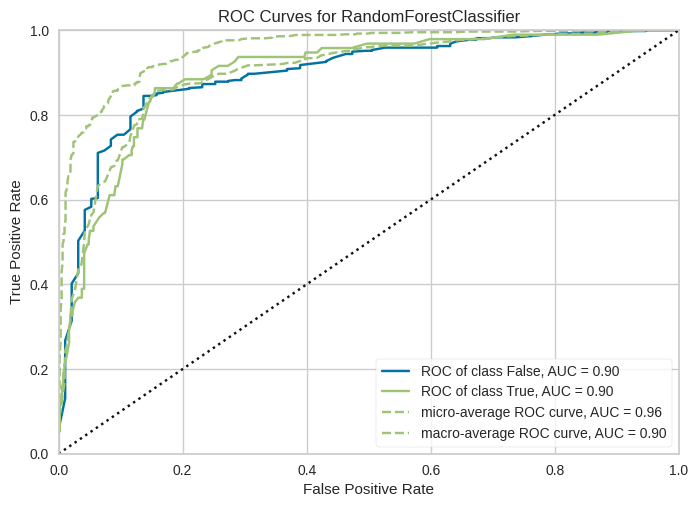

In [92]:
#auc
plot_model(tuned_rf, plot = 'auc')

## Feature Importance

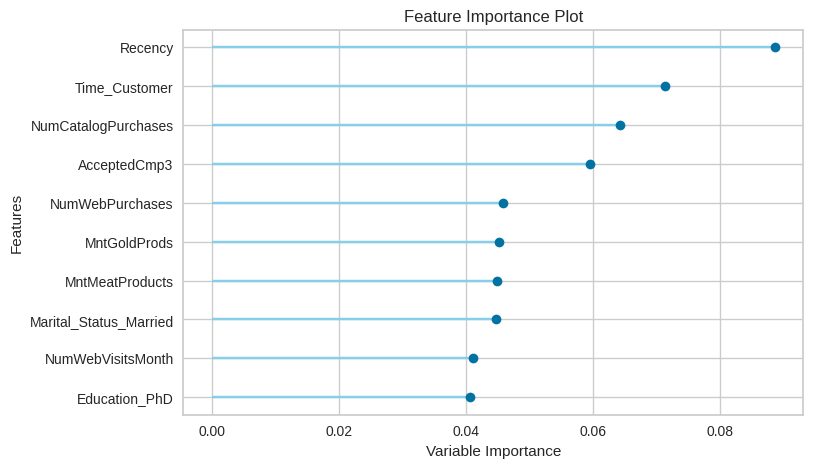

In [93]:
#feature
plot_model(tuned_rf, plot = 'feature')

## Matriz de Confusão

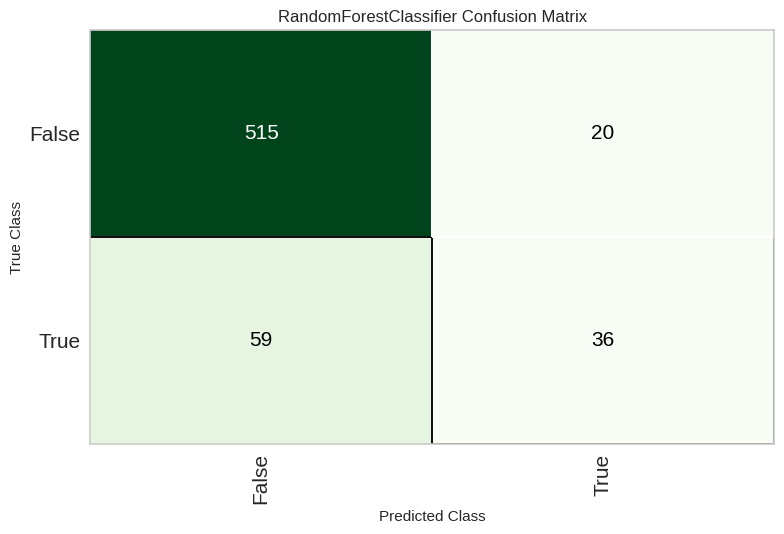

In [94]:
#confusion matrix
plot_model(tuned_rf, plot = 'confusion_matrix')

# Referências:
* https://towardsdatascience.com/introduction-to-binary-classification-with-pycaret-a37b3e89ad8d
* https://pycaret.gitbook.io/docs/get-started/quickstart#classification
* https://pycaret.readthedocs.io/en/latest/api/classification.html#pycaret.classification.plot_model

## Save Model

In [101]:
save_model(mdl_rf, 'pickle_rf_pycaret2')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['AcceptedCmp1', 'AcceptedCmp2',
                                              'AcceptedCmp3', 'AcceptedCmp4',
                                              'AcceptedCmp5', 'Age', 'Complain',
                                              'Income', 'Kidhome',
                                              'MntFishProducts', 'MntFruits',
                                              'MntGoldProds', 'MntMeatProducts',
                                              'MntSweetProducts', 'MntWines',
                                              'NumCatalogPurchases',
                                              'NumDealsPurchase...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         ma

In [96]:
cols_x_test = get_config(variable="X_test").columns
cols_x_test

Index(['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5', 'Age', 'Complain', 'Education', 'Income', 'Kidhome',
       'Marital_Status', 'MntFishProducts', 'MntFruits', 'MntGoldProds',
       'MntMeatProducts', 'MntSweetProducts', 'MntWines',
       'NumCatalogPurchases', 'NumDealsPurchases', 'NumStorePurchases',
       'NumWebPurchases', 'NumWebVisitsMonth', 'Recency', 'Teenhome',
       'Time_Customer'],
      dtype='object')

# Testing in X_test

## 0 - Testing Model

In [129]:
def test_model(model_name):

    # Importa métricas de avaliação do scikit-learn.
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    # Carrega um modelo treinado do PyCaret usando o nome fornecido.
    loaded_model = load_model(model_name)

    # Faz previsões no dataset de validação (df_valid) usando o modelo carregado.
    predictions = predict_model(loaded_model, data=df_valid)

    # Imprime as primeiras linhas das previsões, mostrando a coluna alvo ('Response') e a coluna de previsão ('prediction_label').
    print("Previsões:")
    print(predictions[['Response', 'prediction_label']].head())

    # Verifica se a coluna alvo ('Response') existe no dataset de validação para realizar a avaliação.
    if 'Response' in df_valid.columns:
        # Extrai os valores reais da coluna alvo.
        y_true = df_valid['Response']

        # Extrai os valores previstos.
        y_pred = predictions['prediction_label']

        # Calcula o Erro Quadrático Médio (MSE).
        mse = mean_squared_error(y_true, y_pred)

        # Calcula o Coeficiente de Determinação (R²).
        r2  = r2_score(y_true, y_pred)

        # Calcula o Erro Absoluto Médio (MAE).
        mae = mean_absolute_error(y_true, y_pred)

        # Imprime as métricas de avaliação calculadas.
        print("\nMétricas de Avaliação no Novo Dataset:")
        print(f'Mean Squared Error (MSE): {mse}')
        print(f'R-squared (R²): {r2}')
        print(f'Mean Absolute Error (MAE): {mae}')

    else:
        # Imprime uma mensagem caso a coluna alvo não esteja presente no dataset de validação.
        print("\nO novo dataset não contém a coluna alvo, portanto a avaliação não pode ser feita.")

## 1 - Random Forest - Baseline (82.70%)

In [145]:
# Cria um modelo de Random Forest (mdl_rf) usando a função 'create_model' do PyCaret.
mdl_rf = create_model('rf')

# Otimiza os hiperparâmetros do modelo de Random Forest criado (tuned_rf) usando 'tune_model'.
tuned_rf = tune_model(mdl_rf)

# Faz previsões no dataset de validação (df_valid) com o modelo otimizado e retorna as probabilidades brutas (raw_score=True).
predict_model(tuned_rf, data=df_valid, raw_score = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8636,0.8270,0.1429,0.4000,0.2105,0.1538,0.1786


,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Age,Complain,Education,Income,Kidhome,...,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Teenhome,Time_Customer,Response,prediction_label,prediction_score_0,prediction_score_1
0,0,0,0,0,0,41,0,Graduation,26646,1,...,4,2,6,26,0,11.170428,False,0,0.9900,0.0100
1,0,0,0,0,0,79,0,Graduation,37760,0,...,6,4,7,20,0,12.616007,False,0,0.8500,0.1500
2,0,0,0,0,0,40,0,Master,20559,1,...,3,2,8,88,0,12.087605,False,0,0.9700,0.0300
3,0,0,0,0,0,68,0,Graduation,65486,0,...,10,4,2,29,1,10.921285,False,0,0.9700,0.0300
4,0,0,0,0,0,61,0,Master,79143,0,...,13,6,3,2,0,12.670764,False,0,0.6250,0.3750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0,0,0,0,0,47,0,Basic,26487,1,...,3,2,5,23,0,11.898692,False,0,0.7800,0.2200
106,0,0,0,0,0,42,0,Master,89616,0,...,12,7,2,36,0,12.128669,True,0,0.5700,0.4300
107,0,0,0,0,0,78,0,Graduation,27469,0,...,3,0,6,2,0,12.695405,False,0,0.9567,0.0433
108,0,0,0,0,0,30,0,2n Cycle,80617,0,...,8,4,2,42,0,12.501019,False,0,0.6300,0.3700


## 2 - Linear Discriminant Analysis (81.81%)

In [146]:
# Cria um modelo de Análise Discriminante Linear (LDA) (mdl_lda).
mdl_lda = create_model('lda')

# Otimiza os hiperparâmetros do modelo LDA (tuned_lda) usando 30 folds na validação cruzada,
# 15 iterações na busca e otimizando a métrica AUC.
tuned_lda = tune_model(mdl_lda, fold=30, n_iter=15, optimize='auc')

# Faz previsões no dataset de validação (df_valid) com o modelo LDA otimizado,
# retornando as probabilidades brutas (raw_score=True).
predict_model(tuned_lda, data=df_valid, raw_score = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.7455,0.8181,0.7857,0.3056,0.4400,0.3143,0.3731


,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Age,Complain,Education,Income,Kidhome,...,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Teenhome,Time_Customer,Response,prediction_label,prediction_score_0,prediction_score_1
0,0,0,0,0,0,41,0,Graduation,26646,1,...,4,2,6,26,0,11.170428,False,0,0.9494,0.0506
1,0,0,0,0,0,79,0,Graduation,37760,0,...,6,4,7,20,0,12.616007,False,1,0.4148,0.5852
2,0,0,0,0,0,40,0,Master,20559,1,...,3,2,8,88,0,12.087605,False,0,0.9443,0.0557
3,0,0,0,0,0,68,0,Graduation,65486,0,...,10,4,2,29,1,10.921285,False,0,0.9921,0.0079
4,0,0,0,0,0,61,0,Master,79143,0,...,13,6,3,2,0,12.670764,False,1,0.0513,0.9487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0,0,0,0,0,47,0,Basic,26487,1,...,3,2,5,23,0,11.898692,False,0,0.8128,0.1872
106,0,0,0,0,0,42,0,Master,89616,0,...,12,7,2,36,0,12.128669,True,1,0.3303,0.6697
107,0,0,0,0,0,78,0,Graduation,27469,0,...,3,0,6,2,0,12.695405,False,1,0.2360,0.7640
108,0,0,0,0,0,30,0,2n Cycle,80617,0,...,8,4,2,42,0,12.501019,False,1,0.2351,0.7649


## 3 - Ridge Classifier (76.26%)

In [147]:
# Cria um modelo de Regressão Ridge (mdl_ridge).
mdl_ridge = create_model('ridge')

# Otimiza os hiperparâmetros do modelo Ridge (tuned_ridge) usando 30 folds na validação cruzada,
# 15 iterações na busca e otimizando a métrica AUC.
tuned_ridge = tune_model(mdl_ridge, fold=30, n_iter=15, optimize='auc')

# Faz previsões no dataset de validação (df_valid) com o modelo Ridge otimizado,
# retornando as probabilidades brutas (raw_score=True).
predict_model(tuned_ridge, data=df_valid, raw_score = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.7455,0.7626,0.7857,0.3056,0.4400,0.3143,0.3731


,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Age,Complain,Education,Income,Kidhome,...,NumCatalogPurchases,NumDealsPurchases,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Teenhome,Time_Customer,Response,prediction_label
0,0,0,0,0,0,41,0,Graduation,26646,1,...,0,2,4,2,6,26,0,11.170428,False,0
1,0,0,0,0,0,79,0,Graduation,37760,0,...,1,2,6,4,7,20,0,12.616007,False,1
2,0,0,0,0,0,40,0,Master,20559,1,...,0,2,3,2,8,88,0,12.087605,False,0
3,0,0,0,0,0,68,0,Graduation,65486,0,...,2,1,10,4,2,29,1,10.921285,False,0
4,0,0,0,0,0,61,0,Master,79143,0,...,9,1,13,6,3,2,0,12.670764,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0,0,0,0,0,47,0,Basic,26487,1,...,1,3,3,2,5,23,0,11.898692,False,0
106,0,0,0,0,0,42,0,Master,89616,0,...,5,1,12,7,2,36,0,12.128669,True,1
107,0,0,0,0,0,78,0,Graduation,27469,0,...,0,1,3,0,6,2,0,12.695405,False,1
108,0,0,0,0,0,30,0,2n Cycle,80617,0,...,6,1,8,4,2,42,0,12.501019,False,1


## 4 - LightGBM (81.44%)

In [148]:
# Cria um modelo LightGBM (mdl_gbm).
mdl_gbm = create_model('lightgbm')

# Otimiza os hiperparâmetros do modelo LightGBM (tuned_gbm) usando 30 folds na validação cruzada,
# 15 iterações na busca e otimizando a métrica AUC.
tuned_gbm = tune_model(mdl_gbm, fold=30, n_iter=15, optimize='auc')

# Faz previsões no dataset de validação (df_valid) com o modelo LightGBM otimizado,
# retornando as probabilidades brutas (raw_score=True).
predict_model(tuned_gbm, data=df_valid, raw_score = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8364,0.8144,0.3571,0.3571,0.3571,0.2634,0.2634


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Age,Complain,Education,Income,Kidhome,...,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Teenhome,Time_Customer,Response,prediction_label,prediction_score_0,prediction_score_1
0,0,0,0,0,0,41,0,Graduation,26646,1,...,4,2,6,26,0,11.170428,False,0,0.9953,0.0047
1,0,0,0,0,0,79,0,Graduation,37760,0,...,6,4,7,20,0,12.616007,False,0,0.8434,0.1566
2,0,0,0,0,0,40,0,Master,20559,1,...,3,2,8,88,0,12.087605,False,0,0.9908,0.0092
3,0,0,0,0,0,68,0,Graduation,65486,0,...,10,4,2,29,1,10.921285,False,0,0.9965,0.0035
4,0,0,0,0,0,61,0,Master,79143,0,...,13,6,3,2,0,12.670764,False,0,0.7439,0.2561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0,0,0,0,0,47,0,Basic,26487,1,...,3,2,5,23,0,11.898692,False,0,0.7560,0.2440
106,0,0,0,0,0,42,0,Master,89616,0,...,12,7,2,36,0,12.128669,True,1,0.3376,0.6624
107,0,0,0,0,0,78,0,Graduation,27469,0,...,3,0,6,2,0,12.695405,False,0,0.9377,0.0623
108,0,0,0,0,0,30,0,2n Cycle,80617,0,...,8,4,2,42,0,12.501019,False,1,0.4288,0.5712


## 5 - XGBoost (82.63%)

In [149]:
# Cria um modelo XGBoost (mdl_xgb).
mdl_xgb = create_model('xgboost')

# Otimiza os hiperparâmetros do modelo XGBoost (tuned_xgb) usando 30 folds na validação cruzada,
# 15 iterações na busca e otimizando a métrica AUC.
tuned_xgb = tune_model(mdl_xgb, fold=30, n_iter=15, optimize='auc')

# Faz previsões no dataset de validação (df_valid) com o modelo XGBoost otimizado,
# retornando as probabilidades brutas (raw_score=True).
predict_model(tuned_xgb, data=df_valid, raw_score = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.8000,0.8263,0.8571,0.3750,0.5217,0.4188,0.4761


,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Age,Complain,Education,Income,Kidhome,...,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Teenhome,Time_Customer,Response,prediction_label,prediction_score_0,prediction_score_1
0,0,0,0,0,0,41,0,Graduation,26646,1,...,4,2,6,26,0,11.170428,False,0,0.9981,0.0019
1,0,0,0,0,0,79,0,Graduation,37760,0,...,6,4,7,20,0,12.616007,False,0,0.7179,0.2821
2,0,0,0,0,0,40,0,Master,20559,1,...,3,2,8,88,0,12.087605,False,0,0.9895,0.0105
3,0,0,0,0,0,68,0,Graduation,65486,0,...,10,4,2,29,1,10.921285,False,0,0.9980,0.0020
4,0,0,0,0,0,61,0,Master,79143,0,...,13,6,3,2,0,12.670764,False,1,0.1783,0.8217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0,0,0,0,0,47,0,Basic,26487,1,...,3,2,5,23,0,11.898692,False,1,0.1385,0.8615
106,0,0,0,0,0,42,0,Master,89616,0,...,12,7,2,36,0,12.128669,True,1,0.0999,0.9001
107,0,0,0,0,0,78,0,Graduation,27469,0,...,3,0,6,2,0,12.695405,False,0,0.9518,0.0482
108,0,0,0,0,0,30,0,2n Cycle,80617,0,...,8,4,2,42,0,12.501019,False,1,0.1162,0.8838
